In [ ]:
import scipy.io
import random
import cv2
import numpy as np
import matplotlib.pyplot as plt

# The file wavelet.py contains the function to perform
# the wavelet transform on the images, we saved the functions
# from the numerical tours in this file to get a smaller notebook
from wavelet import *

We will first create functions to simulate various inpainting problems. \\
We will also need to evaluate the reconstruction of the algorithm with the SNR function which is defined like this: <br>
$SNR(Y|X) = 20 \log_{10}\Big[ \frac{||X||}{||X-Y||} \Big]$

In [ ]:
def snr_dB(Y , X):
    """
    This function compute the SNR of Y knowing X
    parameters :
                - Y,X : two signals of the same size.

    returns : the SNR value of Y knowing X.
    """
    X_norm2 = np.sum(X**2)
    diff_norm2 = np.sum((Y - X)**2)
    return 10 * (np.log10(X_norm2/diff_norm2))

def simulate_noise(SNR_value , X):
    """
    This function simulates a noise given a SNR value
    parameters :
                - SNR_value : float , The SNR value fixed.
                - X : signal to which we will add a noise to get SNR_value as SNR

    returns : a tuple 
              - Y : the noised signal
              - sigma : the variance of the noise added to get the SNR_value.
    """
    h,w = X.shape
    # convert X to float32 because we will take the square
    X = X.astype('float32')
    
    # simulate a noise of mean 0 and variance 1
    n = np.random.normal(0 , 1, size = (h,w)) # (0,1)
    # we compute the sigma using the equation above 
    cte = 10**(-SNR_value/10)
    E_x2 = np.sum(X**2)
    E_n2 = np.sum(n**2)
    sigma = np.sqrt(cte * E_x2/E_n2)

    # add the noise*sigma to the signal
    Y = X + sigma * n
    Y = np.clip(Y , 0, 1)
    return Y

def simulate_inpainting(x , p = 0.5 , snr_value = 5):
    """
    This function simulates an inpainting problem
    parameters :
                - x : original signal
                - p : the parameter of the Bernoulli to create the binary matrix A
                - snr_value : given snr value to add the gaussian noise to A*x

    returns : a tuple 
              - y : the noised signal
              - A : the binary matrix with which x was multiplied
    """
    A = np.random.binomial(size = x.shape,n = 1, p = p)
    y = simulate_noise(snr_value , A*x)
    return y, A

In [ ]:
def thresholding(u,t , method='soft'):
    """
    This function is used to perform thresholding operations
    (soft, hard , em)
    """
    if method == 'soft':
        return np.maximum(abs(u)-t, 0) * np.sign(u)
    elif method == 'hard':
        return u * ( np.abs(u) > t)
    elif method == 'em':
        u = np.where(np.abs(u)!=0 , u , 1e-7)
        v = np.maximum(1 - (t/abs(u))**2, 0)
        return u * v

We will generate a random binary matrix A of the same size as the image using a bernoulli distribution with parameter p, then we add white gaussian noise b to generate the direct problem $\textbf{y = Ax + b}$  (where $\textbf{x}$ is the original image).

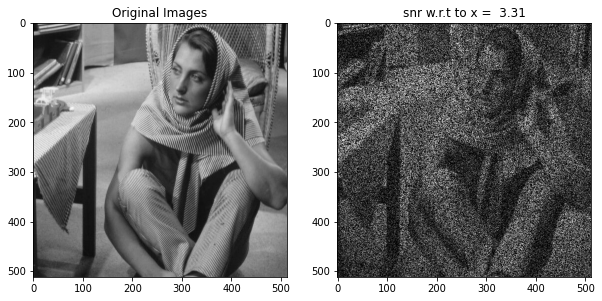

In [ ]:
img = cv2.imread('./data/barbara.jpg')
x = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
x = x.astype('float32')/255

y, A = simulate_inpainting(x)
N = y.shape[0]

fig , (ax1, ax2) = plt.subplots(1, 2, figsize=(10,10))
ax1.imshow(x , cmap="gray")
ax1.set_title('Original Images')
ax2.imshow(y , cmap="gray")
ax2.set_title('snr w.r.t to x = {:5.2f}'.format(snr_dB(y,x)))
plt.show()

In [ ]:
Jmax = np.log2(N)-1
Jmin = Jmax - 3
L = 0.9
LAMBDA = 0.03

# Fast Iterative Shrinkage/Thresholding algorithm (FISTA)

\begin{align*}
    \hat{\alpha} = argmin_{\alpha} \frac{1}{2} || y - A\Phi \alpha||_{_2}^2 + \lambda ||\alpha||_1
\end{align*}

* Initialization $t=0$, $\alpha^{(0)}$, $z^{(0)}$, $\lambda$, $L \leq ||A\Phi||^2$
    
* Do until convergence :

\begin{align*}
         \alpha^{(t+1)} &= \mathbb{S}_{\frac{\lambda}{L}} \Big[ z^{(t)} + \frac{1}{L}\Phi^* A \odot  (y - A\odot \Phi z^{(t)}) \Big] \\
        z^{(t+1)} &= \alpha^{(t+1)} + \frac{t}{t+5} (\alpha^{(t+1)} -\alpha^{(t)} )\\
        t & = t + 1 
\end{align*}
Where $\odot$ is the element-wise product and $\mathbb{S}_{\frac{\lambda}{L}}$ is a tresholding operator. 

## Inpainting using Orthogonal Wavelet Sparsity

In [ ]:
def fista(y, 
          A, 
          Jmin = Jmin, 
          ti = 0,
          L = 0.9, 
          LAMBDA = 0.03, 
          method = 'soft',
          num_iterations = 100):
  
    epsilon = 1e-10
    loss = []
    a_old = np.random.uniform(0,1 , size = y.shape) 
    z_old = perform_wavelet_transf(a_old, Jmin, +1, ti = ti)
    for t in range(num_iterations):
        Phi = perform_wavelet_transf(z_old, Jmin, -1, ti = ti)
        tmp = A * (y - A*Phi)
        Phi_star = perform_wavelet_transf(tmp, Jmin, +1, ti = ti)

        a_new = thresholding( z_old + Phi_star/L ,LAMBDA/L , method = method)
        z_new = a_new + (t/(t+5)) * (a_new - a_old)

        z_old = z_new.copy()
        a_old = a_new.copy()
        
        tmp_aT = perform_wavelet_transf(a_old, Jmin , -1, ti = ti)
        loss.append(0.5*np.sum((y - A*tmp_aT)**2) + LAMBDA * np.sum(np.abs(a_old)))
        if t > 2:
            if np.abs(loss[-1] - loss[-2])**2 < epsilon :
                break

    aT = perform_wavelet_transf(a_old, Jmin , -1, ti = ti)
    return loss , aT

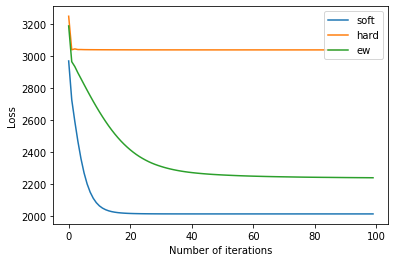

In [ ]:
loss_soft , aT_soft = fista(y, A, method = 'soft')
loss_hard , aT_hard = fista(y, A, method = 'hard')
loss_em , aT_em = fista(y, A, method = 'em')

plt.plot(loss_soft , label = 'soft')
plt.plot(loss_hard ,label = 'hard')
plt.plot(loss_em , label = 'ew')
plt.legend(loc = 'upper right')
plt.xlabel('Number of iterations')
plt.ylabel('Loss')
plt.show()

We launched the algorithm with 3 tresholding methods (described just bellow) for a first experiment with a random choice of $\lambda$, and it turns out that the soft tresholding seems to give the best results while converging earlier than the empirical Wiener. \\
The hard tresholding converges even earlier but gives really bad results, and this is probably due to the choice of $\lambda$ which we will try to fine-tune in the next section. <br> <br>
$\textbf{Soft tresholding}$:
\begin{align*}
    X(\tau,\nu) = Y(\tau,\nu) \Big[ 1 - \frac{\lambda|S(\nu)|}{|Y(\tau,\nu)|}\Big]^+ 
\end{align*}
<br> <br>
$\textbf{Hard tresholding}$:
\begin{align*}
    X(\tau,\nu) = \begin{cases}
      Y(\tau,\nu) & \text{if $|Y(\tau,\nu)| > |S(\nu)| \lambda$}\\
      0 & \text{if $|Y(\tau,\nu)| <= |S(\nu)| \lambda$}\\
    \end{cases}  
\end{align*}
<br> <br>
$\textbf{Empirical Wiener (EW)}$:
$$\mathcal{S}_\lambda^{EW}(\alpha_{tf})=\alpha_{tf}\left(1- \frac{\lambda^2}{|\alpha_{tf}|^2}\right)^+   $$
<br> <br>

Fine tuning $\lambda$ for the thresholding operators.

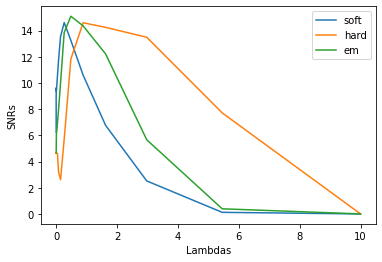

In [ ]:
lambdas = np.logspace( -4 , 1 , 20)
snrs_soft = []
snrs_hard = []
snrs_em = []

for lambda0 in lambdas:
    _ , aT_soft = fista(y , A, method = 'soft', LAMBDA = lambda0)
    _ , aT_hard = fista(y , A, method = 'hard', LAMBDA = lambda0)
    _ , aT_em = fista(y , A, method = 'em', LAMBDA = lambda0)

    snrs_soft.append(snr_dB(aT_soft , x))
    snrs_hard.append(snr_dB(aT_hard , x))
    snrs_em.append(snr_dB(aT_em , x))

plt.plot(lambdas , snrs_soft , label = 'soft')
plt.plot(lambdas , snrs_hard ,label = 'hard')
plt.plot(lambdas , snrs_em , label = 'em')
plt.legend(loc = 'upper right')
plt.xlabel('Lambdas')
plt.ylabel('SNRs')
plt.show()

* The curve of the evolution of the SNR values for different values of $\lambda$ shows that all the thresholding operators achieve almost the same high value of SNR, for a certain $\lambda$.
* The EM thresholding operator achieves the highest value of SNR but not by that far with a great margin from the other thresholding oeprators (soft and hard).

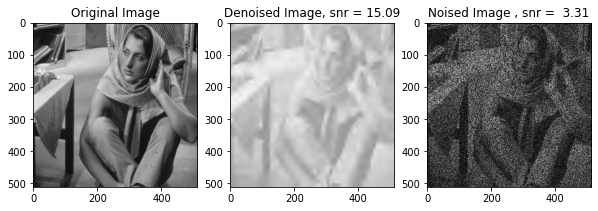

In [ ]:
best_method = 'em'
best_lambda = lambdas[np.argmax(snrs_em)]
_ , aT = fista(y , A, method = best_method, LAMBDA = best_lambda)

fig , (ax1,ax2, ax3) = plt.subplots(1, 3,figsize=(10,10))
ax1.imshow(x, cmap='gray')
ax1.set_title('Original Image')
ax2.imshow(aT, cmap='gray')
ax2.set_title('Denoised Image, snr = {:5.2f}'.format(snr_dB(aT,x)))
ax3.imshow(y, cmap="gray")
ax3.set_title('Noised Image , snr = {:5.2f}'.format(snr_dB(y,x)))
plt.show()

Now we try to reconstruct the original image using the EM thresholding operator and it's best $\lambda$ value associated that give the highest SNR value. \\
* As one can observe, even if the SNR strongly increases, the resulting image remains blurry.

## Inpainting using Translation Invariant Wavelet Sparsity


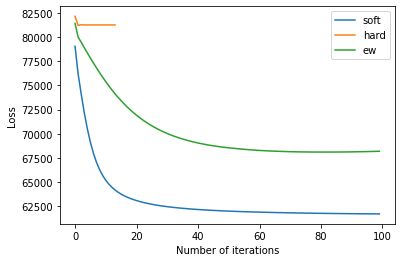

In [ ]:
loss_soft , aT_soft = fista(y , A, method = 'soft', ti = 1)
loss_hard , aT_hard = fista(y, A, method = 'hard', ti = 1)
loss_em , aT_em = fista(y, A, method = 'em', ti = 1)

plt.plot(loss_soft , label = 'soft')
plt.plot(loss_hard ,label = 'hard')
plt.plot(loss_em , label = 'ew')
plt.legend(loc = 'upper right')
plt.xlabel('Number of iterations')
plt.ylabel('Loss')
plt.show()

* The evolution of the loss with the Translation Invariant Wavelet Sparsity are the same as the ones of the orthogonal. 
* The best results are obtained with soft tresholding while the hard tresholding is performing really bad, but this due to the choice of $\lambda$ for this first experiment.

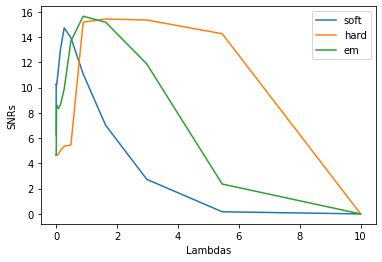

In [ ]:
lambdas = np.logspace( -4 , 1 , 20)
snrs_soft = []
snrs_hard = []
snrs_em = []

for lambda0 in lambdas:
    _ , aT_soft = fista(y , A, method = 'soft', LAMBDA = lambda0, ti = 1)
    _ , aT_hard = fista(y , A, method = 'hard', LAMBDA = lambda0, ti = 1)
    _ , aT_em = fista(y , A, method = 'em', LAMBDA = lambda0, ti = 1)

    snrs_soft.append(snr_dB(aT_soft , x))
    snrs_hard.append(snr_dB(aT_hard , x))
    snrs_em.append(snr_dB(aT_em , x))

plt.plot(lambdas, snrs_soft, label = 'soft')
plt.plot(lambdas, snrs_hard, label = 'hard')
plt.plot(lambdas, snrs_em, label = 'em')
plt.legend(loc = 'upper right')
plt.xlabel('Lambdas')
plt.ylabel('SNRs')
plt.show()

* The curve of the evolution of the SNR values for different values of $\lambda$ shows that all the thresholding operators achieve almost the same high value of SNR, for a certain $\lambda$.
* The EM thresholding operator achieves the highest value of SNR but not by that far with a great margin from the other thresholding oeprators (soft and hard).
* The Hard-thresholding operator achieves high values of SNR for multiple values of $\lambda$.

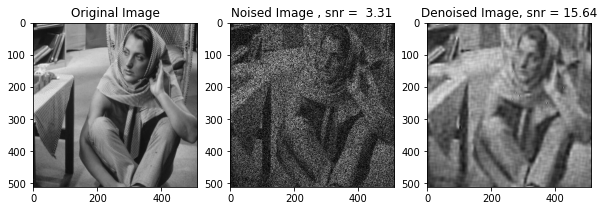

In [ ]:
best_method = 'em'
best_lambda = lambdas[np.argmax(snrs_em)]
_ , aT = fista(y, A, method = best_method, LAMBDA = best_lambda, ti = 1)

fig , (ax1, ax2, ax3) = plt.subplots(1, 3,figsize=(10,10))
ax1.imshow(x, cmap='gray')
ax1.set_title('Original Image')
ax2.imshow(y, cmap="gray")
ax2.set_title('Noised Image , snr = {:5.2f}'.format(snr_dB(y,x)))
ax3.imshow(aT, cmap='gray')
ax3.set_title('Denoised Image, snr = {:5.2f}'.format(snr_dB(aT,x)))
plt.show()

The resulting snr is better thanks to the translation invariant effect (snr = 15.64 against 15.09), and by looking at the image we can see a great improvement on the quality, even if it's still blurry. 

# FISTA with warm restart : (Inpainting with different p values)

In [ ]:
def fista_warm_restart(y, 
                       A, 
                       x,
                       Jmin = Jmin, 
                       ti = 0,
                       L = 0.9, 
                       lambdas = np.logspace(1 , -4 , num = 10), 
                       method = 'soft',
                       num_iterations = 100):
  
    epsilon = 1e-10
    snrs = []
    # random initialization for a
    # z will be initialized with the transform of a
    a_old = np.random.uniform(0, 1 , size = y.shape) 
    z_old = perform_wavelet_transf(a_old, Jmin, +1, ti = ti)
    for lambda0 in lambdas :
        for t in range(num_iterations):
            Phi = perform_wavelet_transf(z_old, Jmin, -1, ti = ti)
            tmp = A * (y - A*Phi)
            Phi_star = perform_wavelet_transf(tmp, Jmin, +1, ti = ti)

            a_new = thresholding( z_old + Phi_star/L ,lambda0/L , method = method)
            z_new = a_new + (t/(t+5)) * (a_new - a_old)

            aT_old_recons = perform_wavelet_transf(a_old, Jmin, -1, ti = ti)
            aT_new_recons = perform_wavelet_transf(a_new, Jmin, -1, ti = ti)            
            snrs.append(snr_dB(aT_new_recons , x))

            if np.sqrt(np.sum((aT_old_recons - aT_new_recons)**2)) < epsilon :
                break
            
            z_old = z_new.copy()
            a_old = a_new.copy()

    return aT_new_recons, snrs

In [ ]:
ps = np.linspace(0.2, 0.95 , num = 8)

snrs_soft_per_p = []
snrs_hard_per_p = []
snrs_em_per_p = []

for p in ps:
    y, A = simulate_inpainting(x , p=p)
    aT_soft , _ = fista_warm_restart(y, A, x, method = 'soft')
    aT_hard , _ = fista_warm_restart(y, A, x, method = 'hard')
    aT_em , _ = fista_warm_restart(y, A, x, method = 'em')

    snrs_soft_per_p.append(snr_dB(aT_soft , x))
    snrs_hard_per_p.append(snr_dB(aT_hard , x))
    snrs_em_per_p.append(snr_dB(aT_em , x))

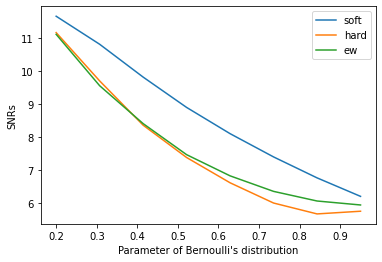

In [ ]:
plt.plot(ps, snrs_soft_per_p, label = 'soft')
plt.plot(ps, snrs_hard_per_p, label = 'hard')
plt.plot(ps, snrs_em_per_p, label = 'ew')
plt.legend(loc = 'upper right')
plt.xlabel('Parameter of Bernoulli\'s distribution')
plt.ylabel('SNRs')
plt.show()

* The soft tresholding remains the best one, and we can see that the SNR values with all the tresholding operators change linearly w.r.t to p the parameter of the bernoulli distribution.
* It's expected to get curves like this, because when the parameter of the bernoulli gets bigger the binary matrix $\textbf{A}$ that will be mutliplied (element-wise product) will cancel more values in the image $\textbf{x}$, hence getting a verry noisy image that's hard to reconstruct from by the FISTA algorithm.

# ------------------------------------------------------------
# ------------------------------------------------------------
# ------------------------------------------------------------

### Team Members
    - Hugo Malard
    - Imad BOUHOU
    
***

# Audio Declipping :

In [ ]:
#!apt install libfftw3-dev
#!apt install liblapack-dev
#!pip install ltfatpy


# Introduction :
In this notebook, we implement the declipping algorithm presented in the paper $\textbf{Audio Declipping with Social Sparsity}$. \\
The algorithm was focusing on improving the declipping procedure with some thresholding operators that take into account the dependencies between the time-frequency coefficients with respect to some dictionaries and specifically for this paper the Gabor transformation. \\
The WGL (Windowed group-Lasso) and PEW (Persistent empirical wiener) showcased improvement in the declipping algorithm. \\

# Problem Definition:
We denote $\textbf{x} \in \mathbb{R}^{T}$ as the original signal (pre-clipping) and $\textbf{y} \in \mathbb{R}^{T}$ as the clipped signal with a certain threshold denoted $\theta^{clip}$
, so the goal of this implementation is to implement an algorithm that reconstructs the original signal $\textbf{x}$. \\
Under the assumption of sparse synthesis coefficients of the signal in a  dictionary $\Phi$, the algorithm aims to optimize this problem :
\begin{equation}
\begin{aligned}
\hat{\alpha} &= argmin_{\alpha} || \alpha ||_0 \\
\textrm{s.t.} \quad &|| y^r - M^r \Phi \alpha ||_{_2}^2 & \leq \epsilon\\
  &  |M^c\Phi\alpha| \geq |\theta^{clip}|   \\
\end{aligned}
\end{equation}
Where $\Phi \in \mathbb{C}^{TxN}$ and $\alpha \in \mathbb{C}^{N}$ represents a dictionary, and in the paper it will represent the Gabor transformation matrix. \\

* The matrix $M^r$ is used to recover the reliable samples of the signal, or the samples that were not clipped and they can be identified because their absolute value is strictly less that $|\theta^{clip}|$. \\
* The matrix $M^c$ is used to recover the clipped samples of the signal, and when we use the clipped signal, we can identify them as the samples such that their absolute value is exactly equal to $|\theta^{clip}|$.
* The first constraint $|| y^r - M^r \Phi \alpha ||_{_2}^2 \leq \epsilon$, signifies that the unclipped samples should stay unmodified during the algorithm as much as possible, so their difference between the original reliable samples at the end of the algorithm has to be less than a certain threshold that we denote by $\epsilon$.
* The second constraint $|M^c\Phi\alpha| \geq |\theta^{clip}|$, signifies that the clipped samples after being reconstructed should be greater than the clipping threshold.

The authors transformed this problem, into an unconstrained convex optimization problem by relaxing the constraint $|M^c\Phi\alpha| \geq |\theta^{clip}|$, and the problem became :
\begin{align*}
  min_{\alpha} \frac{1}{2} || y^r - M^r \Phi \alpha ||_{_2}^2 + \frac{1}{2} \big[ \theta^{clip} - M^c\Phi\alpha \big]^2_{+} + \lambda ||\alpha||_{1}
\end{align*}
This problem can be solved using the ADMM (Alternating Direction Method of Multipliers or Douglas-Rachford algorithm), ISTA or FISTA algorithm but the computation of the steps of the algorithm will results in a soft-thresholding operator by definition, because the problem has a norm $L_1$ constraint, and this operator only takes into account the current synthesis coefficient in time and frequency, and discard the coefficients in the neighborhood. \\

So in the paper $\textbf{Audio Declipping with Social Sparsity}$, the authors suggested to use PEW and WGL operators that use the dependencies of these neighboring coefficients, and using these operators will not correspond directly to the application of the algorithms of FISA or ADMM, but it is proven by the experiments that it yields better results when computing the SNR.


In [ ]:
import scipy.io
import random
import cv2
import matplotlib.pyplot as plt
from scipy.io import wavfile
from scipy.signal import convolve2d
import numpy as np
from ltfatpy import dgtreal, idgtreal, gabwin
from IPython.display import Audio

# Parameters of the model : 
We set the parameters to be the same as the parameters in the experiments section in the paper :

In [ ]:
wtype = 'hann'
w = 1024
a = int(w/4)
M = 2*w
g = gabwin({'name': ('tight', wtype) , 'M' : w}, a, M)[0]

d = 1
gamma = 0.9

Firstly we define the SNR function that will allow us to measure how far our reconstructed signal is from the original one. \\
it is defined this way: <br>
$SNR(Y|X) = 20 \log_{10} \Big[ \frac{||X||}{||X-Y||} \Big] $

In [ ]:
def snr_dB(Y , X):
    """
    This function compute the SNR of Y knowing X
    parameters :
                - Y,X : two signals of the same size.

    returns : the SNR value of Y knowing X.
    """
    X_norm2 = np.sum(X**2)
    diff_norm2 = np.sum((Y - X)**2)
    return 10 * (np.log10(X_norm2/diff_norm2))

In [ ]:
fs, music = wavfile.read('./data/music.wav')
music = music.astype('float64')/2**15

Audio(music, rate = fs)

In [ ]:
fs0, speech = wavfile.read('./data/speech.wav')
speech = speech.astype('float64')/2**15

Audio(speech, rate = fs0)

In [ ]:
def clip_audio(x , theta_c = 0.2):
    y = np.clip(x , -theta_c , theta_c)

    Mr = np.abs(x) < theta_c
    Mc = np.abs(x) >= theta_c

    yr = np.where(Mr , y , 0)
    yc = np.where(Mc , y , 0)

    theta_clip = np.zeros(len(x))
    theta_clip[x >= theta_c] = theta_c
    theta_clip[x <= -theta_c] = -theta_c

    return y, theta_clip, Mr, Mc, yr, yc, x

We construct now a clipped signal $\pmb{y}$ in [- $\theta^{clip}$, $\theta^{clip}$] and we also define the vector of reliable and clipped samples using the matrices $M^r$ and $M^c$: \\
* $\pmb{y^r = M^ry} \in \mathbb{R}^M$ denotes the
reliable samples of the observed signal<br>
* $\pmb{y^c = M^cy} \in \mathbb{R}^{T-M}$ which contains the clipped samples (non-reliable)

In [ ]:
# music_inputs = [ y, theta_clip, Mr, Mc, yr, yc, music ]
music_inputs = clip_audio(music, theta_c = 0.2)

# speech_inputs = [ y, theta_clip, Mr, Mc, yr, yc, speech ]
speech_inputs = clip_audio(speech, theta_c = 0.1)

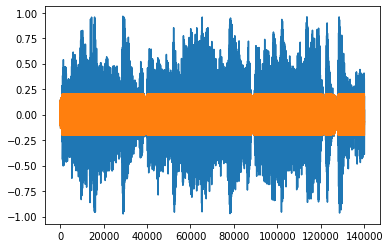

In [ ]:
plt.plot(music)
plt.plot(music_inputs[0])
plt.show()

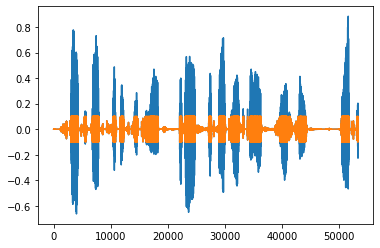

In [ ]:
plt.plot(speech)
plt.plot(speech_inputs[0])
plt.show()

We can hear the clipped signal in order to see how much the music and the speech is noised :

In [ ]:
Audio(music_inputs[0], rate = fs)

In [ ]:
Audio(speech_inputs[0], rate = fs0)

Using the following algorithm we will iterate until convergence in order to get the gabor transform of our declipped signal:

* Initialization: $\boldsymbol{\alpha}^{(0)} \in \mathbb{C}^{N}, \mathbf{z}^{0}=\boldsymbol{\alpha}^{(0)}, k=1, \delta=\left\|\boldsymbol{\Phi} \boldsymbol{\Phi}^{*}\right\| $
<br>
repeat <br>
* $\mathbf{g} 1=-\boldsymbol{\Phi}^{*} \mathbf{M}^{r^{T}}\left(\mathbf{y}^{r}-\mathbf{M}^{r} \boldsymbol{\Phi} \mathbf{z}^{(k-1)}\right);$<br>
* $\mathbf{g} 2=-\boldsymbol{\Phi}^{*} \mathbf{M}^{c^{T}}\left[\boldsymbol{\theta}^{\text {clip }}-\mathbf{M}^{c} \boldsymbol{\Phi} \mathbf{z}^{(k-1)}\right]_+;$<br>
* $\boldsymbol{\alpha}^{(k)}=\mathbb{S}_{\frac{\lambda}{\delta}}\left(\mathbf{z}^{(k-1)}-\frac{1}{\delta}(\mathbf{g} 1+\mathbf{g} 2)\right);$<br>
* $\mathbf{z}^{(k)}=\boldsymbol{\alpha}^{(k)}+\gamma\left(\boldsymbol{\alpha}^{(k)}-\boldsymbol{\alpha}^{(k-1)}\right);$
<br>
* $k=k+1$
<br>
until convergence; <br>
In our experiments we set the value of $\delta$ to 1, but we tried also values like 0.9, and 0.95 and the algorithms always performed the same.

Where $\mathbb{S}$ denotes the tresholding method, $\Phi^*$ is the analysis operator, and $\Phi$ is the synthesis operator. \\
These are the thresholding operators used : \\
$\textbf{Hard tresholding (HT)}$:
\begin{align*}
    X(\tau,\nu) = \begin{cases}
      Y(\tau,\nu) & \text{if $|Y(\tau,\nu)| > |S(\nu)| \lambda$}\\
      0 & \text{if $|Y(\tau,\nu)| <= |S(\nu)| \lambda$}\\
    \end{cases}  
\end{align*}
<br> <br>
$\textbf{Persistent Empirical Wiener (PEW)}$:
$$\mathcal{S}_\lambda^{PEW}(\alpha_{tf})=\alpha_{tf}\left(1- \frac{\lambda^2}{\Sigma_{t'\in\mathcal{N}(t)}|\alpha_{t'f}|^2}\right)^+   $$
<br> <br>
$\textbf{Empirical Wiener (EW)}$:
$$\mathcal{S}_\lambda^{EW}(\alpha_{tf})=\alpha_{tf}\left(1- \frac{\lambda^2}{|\alpha_{tf}|^2}\right)^+   $$
<br> <br>
$\textbf{Lasso}$:
$$\mathcal{S}_\lambda^{LASSO}(\alpha_{tf})=\alpha_{tf}\left(1- \frac{\lambda}{|\alpha_{tf}|}\right)^+   $$
<br> <br>
$\textbf{Windowed Group-Lasso(WGL)}$:
$$\mathcal{S}_\lambda^{WGL}(\alpha_{tf})=\alpha_{tf}\left(1- \frac{\lambda}{\sqrt{\Sigma_{t'\in\mathcal{N}(t)}|\alpha_{t'f}|^2}}\right)^+   $$

The operators PEW and WGL that require neighborhood coeffiecients to be computes, can be compute like a convolution, and in the paper the authors mentioned that the padding that was used in their experiemnts was not zero-padding but was reflection padding a.k.a symmetrical padding.

In [ ]:
def thresholding(u , t , method = 'PEW', ks = (3,3)):
    kernel = np.ones(ks)
    if method == 'HT':
        ut = np.abs(u) > t
        return u*ut
    
    elif method == 'L':
        ut = np.abs(u)
        ut = np.maximum(ut , 1e-7)
        return u * np.maximum(1 - t/ut , 0)
    
    elif method == 'WGL':
        ut = np.abs(u)**2
        ut = convolve2d(ut, kernel, mode='same', boundary = 'symm')
        ut = np.sqrt(ut)
        ut = np.maximum(ut , 1e-7)
        return u * np.maximum(1 - t/ut , 0)

    elif method == 'EW':
        ut = np.abs(u)**2
        ut = np.maximum(ut , 1e-7)
        ut = 1 - t**2/ut
        return u * np.maximum(ut , 0)

    elif method == 'PEW':
        ut = np.abs(u)**2
        ut = convolve2d(ut, kernel, mode='same', boundary = 'symm')
        ut = np.maximum(ut , 1e-7)
        ut = 1 - t**2/ut
        return u * np.maximum(ut , 0)
    else :
        print('Thresholding method unknown method must be in {HT, L, WGL , EW, PEW}, method given : ' + method)

In [ ]:
def fista_warm_restart(inputs, 
                       num_iterations = 50, 
                       method = 'HT', 
                       ks = (3,3), # number of neighboors for PEW and WGL
                       lambdas = np.logspace(-1 , -4 , num = 10)):
    epsilon = 1e-10
    y, theta_clip, Mr, Mc, yr, yc, x = inputs
    snrs = []
    
    N = len(y)
    a_old = dgtreal(y, g, a, M)[0]
    z_old = np.zeros(a_old.shape).astype('complex128')
    for lambda0 in lambdas:
        for t in range(num_iterations) :
            phi_z = idgtreal(z_old ,g ,a ,M ,N)[0]

            r1 = yr - np.where(Mr , phi_z , 0)
            g1 = - dgtreal(r1 ,g ,a ,M)[0]

            r2 = theta_clip - np.where(Mc , phi_z , 0)
            r2[np.abs(phi_z) > np.abs(theta_clip)] = 0
            g2 = - dgtreal(r2 ,g ,a ,M)[0]

            a_new = thresholding(z_old - 1/d * (g1 + g2), lambda0/d, method=method ,ks = ks)
            z_new = a_new + gamma * (a_new - a_old)

            aT_old_recons = idgtreal(a_old ,g ,a ,M, N)[0]
            aT_old_recons = np.clip(aT_old_recons , -1 , 1)
            aT_new_recons = idgtreal(a_new ,g ,a ,M, N)[0]
            aT_new_recons = np.clip(aT_new_recons , -1 , 1)
            snrs.append(snr_dB(aT_new_recons[Mc] , x[Mc]))

            if np.sqrt(np.sum((aT_old_recons - aT_new_recons)**2)) < epsilon :
                break
            a_old = a_new.copy()
            z_old = z_new.copy()

    return aT_new_recons, snrs

In [ ]:
snrs_music = {}
for method in ['HT' , 'L' , 'WGL' ,'EW', 'PEW']:
    _, snr_tmp = fista_warm_restart(music_inputs , method = method)
    snrs_music[method] = snr_tmp

In [ ]:
snrs_speech = {}
for method in ['HT' , 'L' , 'WGL' ,'EW', 'PEW']:
    _, snr_tmp = fista_warm_restart(speech_inputs , method = method)
    snrs_speech[method] = snr_tmp

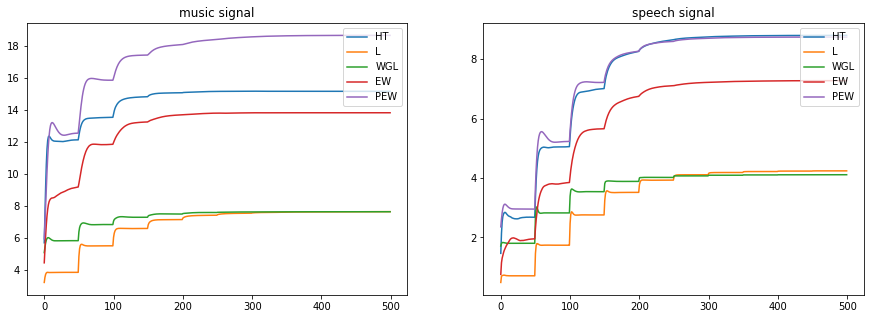

In [ ]:
fig , (ax1, ax2) = plt.subplots(1,2 , figsize =(15,5))

for key, value in snrs_music.items():
    ax1.plot(snrs_music[key] , label = key)

for key, value in snrs_speech.items():
    ax2.plot(snrs_speech[key] , label = key)

ax1.legend(loc="upper right")
ax1.set_title("music signal")
ax2.legend(loc="upper right")
ax2.set_title("speech signal")
plt.show()

We can observe the results for the different tresholdings used. 
* The best one seems clearly to be the Persistent Empirical Wiener (PEW) for the music signal but for the speech signal PEW and Hard-thresholding give almost the same results with HT a little bit better, while the 2 LASSO based methods seems to be the "worst". \\

In [ ]:
at_music, _ = fista_warm_restart(music_inputs , method = 'PEW')
Audio(at_music, rate = fs)

As we guessed by hearing the recontructed signal, it's very close to the original one, especially for the music signal. 

In [ ]:
at_speech, _ = fista_warm_restart(speech_inputs , method = 'PEW')
Audio(at_speech, rate = fs0)

As we can hear, the results obtained by the algorithm with PEW tresholding are pretty good, the reconstructed signal is really close to the original one.

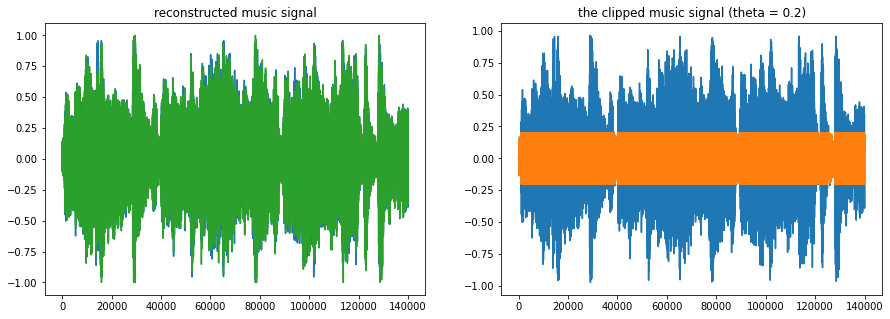

In [ ]:
fig , (ax1,ax2) = plt.subplots(1, 2 , figsize=(15,5))
ax1.plot(music)
ax1.plot(music_inputs[0])
ax1.plot(at_music)
ax1.set_title('reconstructed music signal')
ax2.plot(music)
ax2.plot(music_inputs[0])
ax2.set_title('the clipped music signal (theta = 0.2)')
plt.show()

The algorithm almost managed to reconstruct the clipped samples in the case of the music.

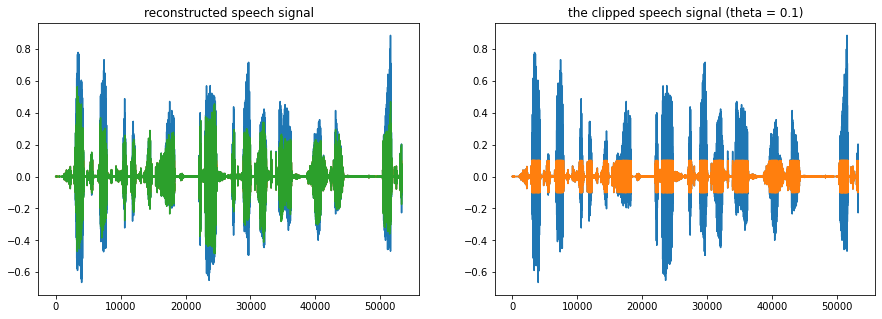

In [ ]:
fig , (ax1,ax2) = plt.subplots(1, 2 , figsize=(15,5))
ax1.plot(speech)
ax1.plot(speech_inputs[0])
ax1.plot(at_speech)
ax1.set_title('reconstructed speech signal')
ax2.plot(speech)
ax2.plot(speech_inputs[0])
ax2.set_title('the clipped speech signal (theta = 0.1)')
plt.show()

* The algorithm almost managed to reconstruct the clipped samples in the case of the speech.
* The speech signal might have been strongly clipped, but still the algorithm managed to reconstruct most of the clipped samples.

# Declipping for different values of $\theta^{clip}$:

We now know that with clipping value of 0.2 the algorithm is able to reconstruct quite well the signal. But how much is it powerful, can the algorithm perform well also when the signal is even more clipped, so we will take different values of $\theta^{clip}$ and see how the perforamnce of the algorithm will evolve.

In [ ]:
thetas = np.linspace(0.05, 0.95 , num = 10)

snrs_PEW_music = []
snrs_EW_music = []
snrs_WGL_music = []
snrs_L_music = []
snrs_HT_music = []

for theta_c0 in thetas:
    inputs = clip_audio(music, theta_c = theta_c0)
    at_PEW, _ = fista_warm_restart(inputs, method = 'PEW')
    at_EW , _ = fista_warm_restart(inputs, method = 'EW')
    at_WGL, _ = fista_warm_restart(inputs, method = 'WGL')
    at_L  , _ = fista_warm_restart(inputs, method = 'L')
    at_HT , _ = fista_warm_restart(inputs, method = 'HT')

    snrs_PEW_music.append(snr_dB(at_PEW , music))
    snrs_EW_music.append(snr_dB(at_EW , music))
    snrs_WGL_music.append(snr_dB(at_WGL , music))
    snrs_L_music.append(snr_dB(at_L , music))
    snrs_HT_music.append(snr_dB(at_HT , music))

snrs_PEW_speech = []
snrs_EW_speech = []
snrs_WGL_speech = []
snrs_L_speech = []
snrs_HT_speech = []

for theta_c0 in thetas:
    inputs = clip_audio(speech, theta_c = theta_c0)
    at_PEW, _ = fista_warm_restart(inputs, method = 'PEW')
    at_EW , _ = fista_warm_restart(inputs, method = 'EW')
    at_WGL, _ = fista_warm_restart(inputs, method = 'WGL')
    at_L  , _ = fista_warm_restart(inputs, method = 'L')
    at_HT , _ = fista_warm_restart(inputs, method = 'HT')

    snrs_PEW_speech.append(snr_dB(at_PEW , speech))
    snrs_EW_speech.append(snr_dB(at_EW , speech))
    snrs_WGL_speech.append(snr_dB(at_WGL , speech))
    snrs_L_speech.append(snr_dB(at_L , speech))
    snrs_HT_speech.append(snr_dB(at_HT , speech))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in float_scalars
  del sys.path[0]


We lauched the algorithm for 10 different values of $\theta^{clip}$ using all the different tresholdings in order to see its behaviour.

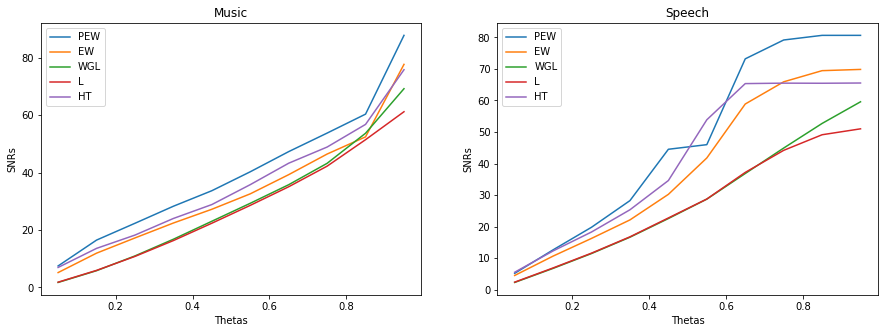

In [ ]:
fig , (ax1, ax2) = plt.subplots(1, 2 , figsize = (15,5))

ax1.plot(thetas, snrs_PEW_music, label = 'PEW')
ax1.plot(thetas, snrs_EW_music, label = 'EW')
ax1.plot(thetas, snrs_WGL_music, label = 'WGL')
ax1.plot(thetas, snrs_L_music, label = 'L')
ax1.plot(thetas, snrs_HT_music, label = 'HT')
ax1.legend(loc = 'upper left')
ax1.set_xlabel('Thetas')
ax1.set_ylabel('SNRs')
ax1.set_title('Music')

ax2.plot(thetas, snrs_PEW_speech, label = 'PEW')
ax2.plot(thetas, snrs_EW_speech, label = 'EW')
ax2.plot(thetas, snrs_WGL_speech, label = 'WGL')
ax2.plot(thetas, snrs_L_speech, label = 'L')
ax2.plot(thetas, snrs_HT_speech, label = 'HT')
ax2.legend(loc = 'upper left')
ax2.set_xlabel('Thetas')
ax2.set_ylabel('SNRs')
ax2.set_title('Speech')

plt.show()

One can observe that the SNR values of the reconstructed signal change in a linear way with respect to the values of clipping $\theta^{clip}$, except after 0.8 where it increases really fast, because after that the signal is mainly not hardly clipped. \\
The PEW tresholding also seems to be the best one, for any clipping value. \\
In summary one could say that starting from $\theta^{clip} ≈ 0.15$ the reconstructed signals from the algorithm are good.

# Reconstruction with different of coefficients in the neighborhood using PEW:

In [ ]:
snrs_music = {}
for a_ks in [3, 5, 7, 9]:
    _, snr_tmp = fista_warm_restart(music_inputs, method = 'PEW' , ks = (a_ks, a_ks))
    snrs_music[str(a_ks)] = snr_tmp

In [ ]:
snrs_speech = {}
for a_ks in [3, 5, 7, 9]:
    _, snr_tmp = fista_warm_restart(speech_inputs, method = 'PEW' , ks = (a_ks, a_ks))
    snrs_speech[str(a_ks)] = snr_tmp

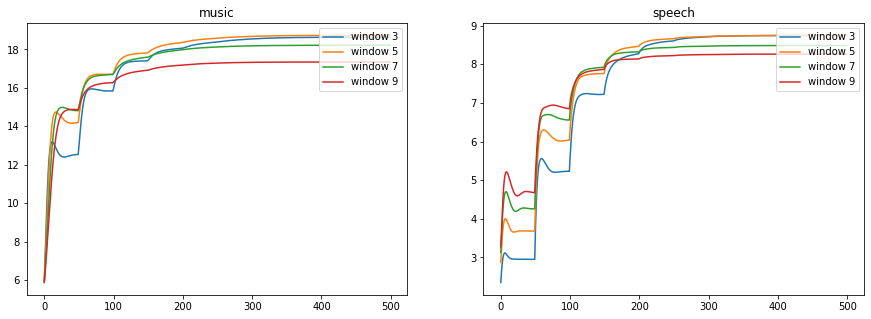

In [ ]:
fig , (ax1, ax2) = plt.subplots(1,2 , figsize =(15,5))

for key, value in snrs_music.items():
    ax1.plot(snrs_music[key] , label = 'window ' + str(key))

for key, value in snrs_speech.items():
    ax2.plot(snrs_speech[key] , label = 'window ' + str(key))

ax1.legend(loc="upper right")
ax1.set_title("music")
ax2.legend(loc="upper right")
ax2.set_title("speech")
plt.show()

We launched the algorithm for multiple window sizes when computing the PEW operator. \\
From the figures, we can see that there is a small gain of SNR as the size of the windows gets smaller, and for a window of size (3,3) we get the best results, which confirms what was said in the paper that smaller windows are more beneficial than larger ones.

# Conclusion:
In this notebook, we managed to implement the algorithm presented in the paper, and we made some experiments to reproduce the same results as the paper, and also to confirm some conclusions presented in the paper. \\
PEW operator yields better results in almost all the experiments, except for the speech signal where the hard-thresholding outperformed the PEW operator. \\
When the level of clipping grows, the declipping algorithm manages to reconstruct the signal as expected both for the music and speech cases. \\
At the last experiment, we tried to see how if the size of the window with the PEW operator will improve the reconstruction, and it turns out that smaller windows which tend to be faster to compute with a convolution and yield better results. \\
The authors of the paper suggested to continue future works on the theoretical sides of relation between PEW operator and the ISTA algorithms. \\
The soft-thresholding operator will be found by definition (L1-norm for the constraint with $\lambda$) if we tried to solve the minimization problem by the ADMM (Douglas-Rachford algorithm) or the FISTA to compute the steps of the algorithm, but the authors suggested to replace it with PEW for example, which raises a question of what should be the minimization problem so that when we try to solve it using the ADMM or FISTA we get by definition the PEW as a thresholding operator.